# Library import

In [3]:
import os, sys
import torch
sys.path.append(os.path.dirname(os.path.join(os.getcwd()))) 
from data_utils.data_utils import DataUtils
from model.lstm import LSTM
from data_set.LSTMDataset import LSTMDataSet
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# Split the dataset into train and validation

In [4]:
training_set = torch.utils.data.TensorDataset(LSTMDataSet().X[:1000,:,:].float(), LSTMDataSet().Y[:1000].float())
training_generator = DataLoader(training_set, batch_size=700, shuffle=False)
validation_set = torch.utils.data.TensorDataset(LSTMDataSet().X[1000:,:,:].float(), LSTMDataSet().Y[1000:].float())
validation_generator = DataLoader(validation_set, batch_size=119, shuffle=False)

# Define the LSTM model

In [5]:
model = LSTM()
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model

In [6]:
num_epochs = 50
hist_train, hist_val = np.empty(num_epochs), np.empty(num_epochs)

for epoch in range(num_epochs):
    
    optimizer.zero_grad()
    
    for X_train, Y_train in training_generator:
        Y_train_pred = model(X_train)
        train_loss = loss_fn(Y_train_pred, Y_train)
    
    with torch.set_grad_enabled(False):
        for X_val, Y_val in validation_generator:
            Y_val_pred = model(X_val)
            val_loss = loss_fn(Y_val_pred, Y_val)
    
    if epoch % 10 == 0 and epoch !=0:
        print("Epoch:", epoch, "|", "Training MSE Loss :", round(train_loss.item(), 10), "|", "Validation MSE Loss:", round(val_loss.item(), 10))
        
    hist_train[epoch], hist_val[epoch] = train_loss.item(), val_loss.item()
    
    # Backward pass
    train_loss.backward()

    # Update parameters
    optimizer.step()

Epoch: 10 | Training MSE Loss : 0.015218256 | Validation MSE Loss: 0.2337647974
Epoch: 20 | Training MSE Loss : 0.0122444741 | Validation MSE Loss: 0.1280021071
Epoch: 30 | Training MSE Loss : 0.0102367224 | Validation MSE Loss: 0.1620194167
Epoch: 40 | Training MSE Loss : 0.0078562917 | Validation MSE Loss: 0.0969896466


# Draw the result

In [7]:
Y = LSTMDataSet().Y.numpy()
Y_train_pred = model(LSTMDataSet().X[:1000,:,:].float())
Y_val_pred = model(LSTMDataSet().X[1000:,:,:].float())

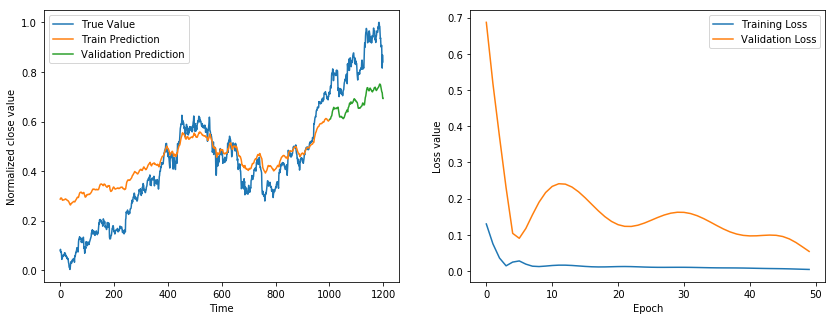

In [8]:
f, (ax_pred, ax_loss) = plt.subplots(1, 2, figsize=(14,5))

ax_pred.plot(LSTMDataSet().Y, label="True Value")
ax_pred.plot(Y_train_pred.detach().numpy(), label="Train Prediction")
ax_pred.plot(
    range(Y_train_pred.detach().numpy().shape[0] + 1, 1 + Y_train_pred.detach().numpy().shape[0] + Y_val_pred.detach().shape[0]),
    Y_val_pred.detach().numpy(),
    label="Validation Prediction"
)
ax_pred.set_xlabel("Time")
ax_pred.set_ylabel("Normalized close value")
ax_pred.legend()

ax_loss.plot(hist_train, label="Training Loss")
ax_loss.plot(hist_val, label="Validation Loss")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss value")
ax_loss.legend()
plt.show()

# Hyperparameter Search

In [ ]:
loss_fn = torch.nn.MSELoss(reduction='mean')
num_layers_candidate, drop_prob_candidate, lr_candidate = [1, 2, 3], [0.3, 0.5], [0.01, 0.03]
best_loss, best_lr, best_num_layers, best_prob, best_window = 0.0, 0.0, 0.0, 0.0, 0.0
window_candidate = [60,80,100]

for window in window_candidate:
    
    dataset = LSTMDataSet(window=window)
    training_set = torch.utils.data.TensorDataset(dataset.X[:1000,:,:].float(), dataset.Y[:1000].float())
    training_generator = DataLoader(training_set, batch_size=700, shuffle=False)
    validation_set = torch.utils.data.TensorDataset(dataset.X[1000:,:,:].float(), dataset.Y[1000:].float())
    validation_generator = DataLoader(validation_set, batch_size=119, shuffle=False)

    for epoch in range(num_epochs):

        for item in product(num_layers_candidate, lr_candidate, drop_prob_candidate):

            model = LSTM(num_layers=item[0], drop_prob=item[2])

            optimizer = torch.optim.Adam(model.parameters(), lr=item[1])

            optimizer.zero_grad()

            for X_train, Y_train in training_generator:
                Y_train_pred = model(X_train)
                train_loss = loss_fn(Y_train_pred, Y_train)

            with torch.set_grad_enabled(False):
                for X_val, Y_val in validation_generator:
                    Y_val_pred = model(X_val)
                    val_loss = loss_fn(Y_val_pred, Y_val)

            if epoch == 0:
                best_loss = val_loss.item()

            else:
                if best_loss > val_loss.item():
                    best_loss = val_loss.item()
                    best_num_layers, best_lr, best_prob, best_window = item[0], item[1], item[2], window
                    
            train_loss.backward()

            optimizer.step()

In [ ]:
best_num_layers, best_lr, best_prob, best_window